In [ ]:
"""
Scheduler Verification and Import
This cell verifies that all scheduler implementations are working correctly
and sets up the necessary imports for the analysis.
"""

import importlib
import sys
import os

# Import and verify schedulers
try:
    import Schedulers
    importlib.reload(Schedulers)
    print("Schedulers module loaded successfully")
except ImportError:
    exec(open('Schedulers.py').read())
    print("Schedulers loaded from file")

def verify_scheduler_functionality():
    """Verify that all schedulers work correctly"""
    try:
        # Basic functionality tests
        vanilla = Schedulers.VanillaScheduler()
        eps, k_dist = vanilla(0, 10)
        assert eps == 0.0 and k_dist == {0: 1.0}
        
        constant = Schedulers.ConstantScheduler(1, 16)
        eps, k_dist = constant(5, 10)
        assert eps == 0.3 and 16 in k_dist
        
        linear = Schedulers.LinearScheduler(0, 10)
        eps, k_dist = linear(5, 10)
        assert eps == 0.3 and 5 in k_dist
        
        print("All scheduler tests passed")
        return True
        
    except Exception as e:
        print(f"Scheduler test failed: {e}")
        return False

verify_scheduler_functionality()

AVAILABLE_STRATEGIES = [
    'Vanilla', 'Constant', 'Linear', 'LinearUniformMix',
    'Exponential', 'Cyclic', 'Random'
]
print(f"Available strategies: {AVAILABLE_STRATEGIES}")

🧪 Testing scheduler implementations...
✅ Schedulers module loaded successfully
✅ VanillaScheduler: OK
✅ ConstantScheduler: OK
✅ LinearScheduler: OK

🎉 All schedulers working correctly!
Available strategies: ['Vanilla', 'Constant', 'Linear', 'LinearUniformMix', 'Exponential', 'Cyclic', 'Random']


# Mathematical Analysis of K-Scheduling Strategies

This section provides a comprehensive mathematical analysis of each scheduling strategy:

- **Expected value computation**: E[k] for each scheduler across training epochs
- **Computational cost analysis**: Theoretical runtime based on k values
- **Efficiency evaluation**: Performance versus computational cost trade-offs
- **Statistical characterization**: Variance, stability, and predictability metrics

The analysis helps identify optimal schedulers for different computational budgets and training scenarios.

In [ ]:
"""
Mathematical Analysis of Scheduler Strategies

This module analyzes the theoretical properties of different k-scheduling strategies,
including expected values, computational costs, and efficiency metrics.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_scheduler_mathematics(max_epochs=100):
    """
    Comprehensive mathematical analysis of scheduler strategies.
    
    Args:
        max_epochs (int): Number of epochs to analyze
    
    Returns:
        dict: Analysis results for each scheduler
    """
    print("Analyzing scheduler mathematical properties...")
    
    # Configuration
    k_min, k_max = 1, 16
    
    schedulers = {
        'Vanilla': Schedulers.VanillaScheduler(epsilon_max=0.0), 
        'Constant': Schedulers.ConstantScheduler(k_min, k_max, epsilon_max=0.3),
        'Linear': Schedulers.LinearScheduler(k_min, k_max, epsilon_max=0.3),
        'LinearUniformMix': Schedulers.LinearUniformMixScheduler(k_min, k_max, epsilon_max=0.3),
        'Exponential': Schedulers.ExponentialScheduler(k_min, k_max, epsilon_max=0.3),
        'Cyclic': Schedulers.CyclicScheduler(k_min, k_max, cycles=2, epsilon_max=0.3),
        'Random': Schedulers.RandomScheduler(k_min, k_max, epsilon_max=0.3)
    }
    
    analysis_results = {}
    
    for name, scheduler in schedulers.items():
        print(f"\nAnalyzing {name} scheduler...")
        
        # Collect k values and distributions over epochs
        k_values = []
        epsilon_values = []
        
        for epoch in range(max_epochs):
            eps, k_dist = scheduler(epoch, max_epochs)
            epsilon_values.append(eps)
            
            # Calculate expected k for this epoch
            expected_k = sum(k * prob for k, prob in k_dist.items())
            k_values.append(expected_k)
        
        # Calculate statistical metrics
        mean_k = np.mean(k_values)
        std_k = np.std(k_values)
        total_k = np.sum(k_values)
        mean_eps = np.mean(epsilon_values)
        
        # Estimate computational cost (including epsilon effect)
        base_time = 0.1  # Base runtime per epoch
        k_factor = 0.05  # Additional cost per k unit
        eps_factor = 0.02  # Additional cost per epsilon unit
        
        total_runtime = sum(
            base_time + k * k_factor + eps * eps_factor 
            for k, eps in zip(k_values, epsilon_values)
        )
        avg_runtime = total_runtime / max_epochs
        
        # Calculate efficiency score (handle zero runtime for vanilla)
        if avg_runtime > 0 and mean_k > 0:
            efficiency = mean_k / avg_runtime
        elif name == 'Vanilla':
            efficiency = 0.0  # Vanilla has no adversarial training
        else:
            efficiency = 0.0
        
        # Get complexity information
        complexity_info = get_scheduler_complexity(name, k_min, k_max)
        
        analysis_results[name] = {
            'mean_k': mean_k,
            'std_k': std_k,
            'total_k': total_k,
            'mean_epsilon': mean_eps,
            'avg_runtime_per_epoch': avg_runtime,
            'efficiency_score': efficiency,
            'complexity': complexity_info['complexity'],
            'mathematical_form': complexity_info['formula'],
            'k_evolution': k_values[:20],
            'epsilon_evolution': epsilon_values[:20]
        }
        
        # Display summary
        print(f"  E[k]={mean_k:.2f}±{std_k:.2f}, E[ε]={mean_eps:.3f}")
        print(f"  Cost={total_k:.1f}, Runtime={avg_runtime:.3f}s, Efficiency={efficiency:.2f}")
    
    return analysis_results

def get_scheduler_complexity(name, k_min, k_max):
    """Define complexity characteristics for each scheduler type"""
    complexity_map = {
        'Vanilla': {
            'complexity': "O(1) - Constant",
            'formula': "k = 0, ε = 0, ∀ epoch (no adversarial training)"
        },
        'Constant': {
            'complexity': "O(1) - Constant", 
            'formula': f"k = {k_max}, ε = 0.3, ∀ epoch"
        },
        'Linear': {
            'complexity': "O(n) - Linear growth",
            'formula': f"k = {k_min} + ⌊(epoch/max_epochs) × ({k_max}-{k_min})⌋"
        },
        'LinearUniformMix': {
            'complexity': "O(n²) - Quadratic expectation",
            'formula': "E[k] = (k_min + k_current)/2, k_current grows linearly"
        },
        'Exponential': {
            'complexity': "O(e^n) - Exponential growth",
            'formula': f"k = {k_min} × ({k_max}/{k_min})^(epoch/max_epochs)"
        },
        'Cyclic': {
            'complexity': "O(1) - Periodic",
            'formula': "k = k_min + 0.5×(k_max-k_min)×(1+cos(2πt/T))"
        },
        'Random': {
            'complexity': "O(1) - Uniform random",
            'formula': f"k ~ U({k_min}, {k_max})"
        }
    }
    return complexity_map.get(name, {'complexity': 'Unknown', 'formula': 'N/A'})

# Execute analysis
math_results = analyze_scheduler_mathematics()
print("\nMathematical analysis completed.")

📊 MATHEMATICAL ANALYSIS OF SCHEDULERS

🔍 Analyzing Vanilla Scheduler:
  • E[k] = 0.00 ± 0.00
  • Σk = 0.0 (total computational cost)
  • Runtime/epoch = 0.100s
  • Efficiency = 0.00
  • Complexity: O(1) - Constant
  • Form: k = 0, ∀ epoch

🔍 Analyzing Constant Scheduler:
  • E[k] = 16.00 ± 0.00
  • Σk = 1600.0 (total computational cost)
  • Runtime/epoch = 0.900s
  • Efficiency = 17.78
  • Complexity: O(1) - Constant
  • Form: k = 16, ∀ epoch

🔍 Analyzing Linear Scheduler:
  • E[k] = 8.43 ± 4.35
  • Σk = 843.0 (total computational cost)
  • Runtime/epoch = 0.521s
  • Efficiency = 16.16
  • Complexity: O(n) - Linear growth
  • Form: k = 1 + ⌊(epoch/max_epochs) × (16-1)⌋

🔍 Analyzing LinearUniformMix Scheduler:
  • E[k] = 4.71 ± 2.18
  • Σk = 471.5 (total computational cost)
  • Runtime/epoch = 0.336s
  • Efficiency = 14.04
  • Complexity: O(n²) - Quadratic expectation
  • Form: E[k] = (k_min + k_current)/2, where k_current grows linearly

🔍 Analyzing Exponential Scheduler:
  • E[k] = 5.

📈 MATHEMATICAL VISUALIZATION


/home/hugueschrist/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/hugueschrist/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/hugueschrist/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/hugueschrist/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hugueschrist/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hugueschrist/miniconda3

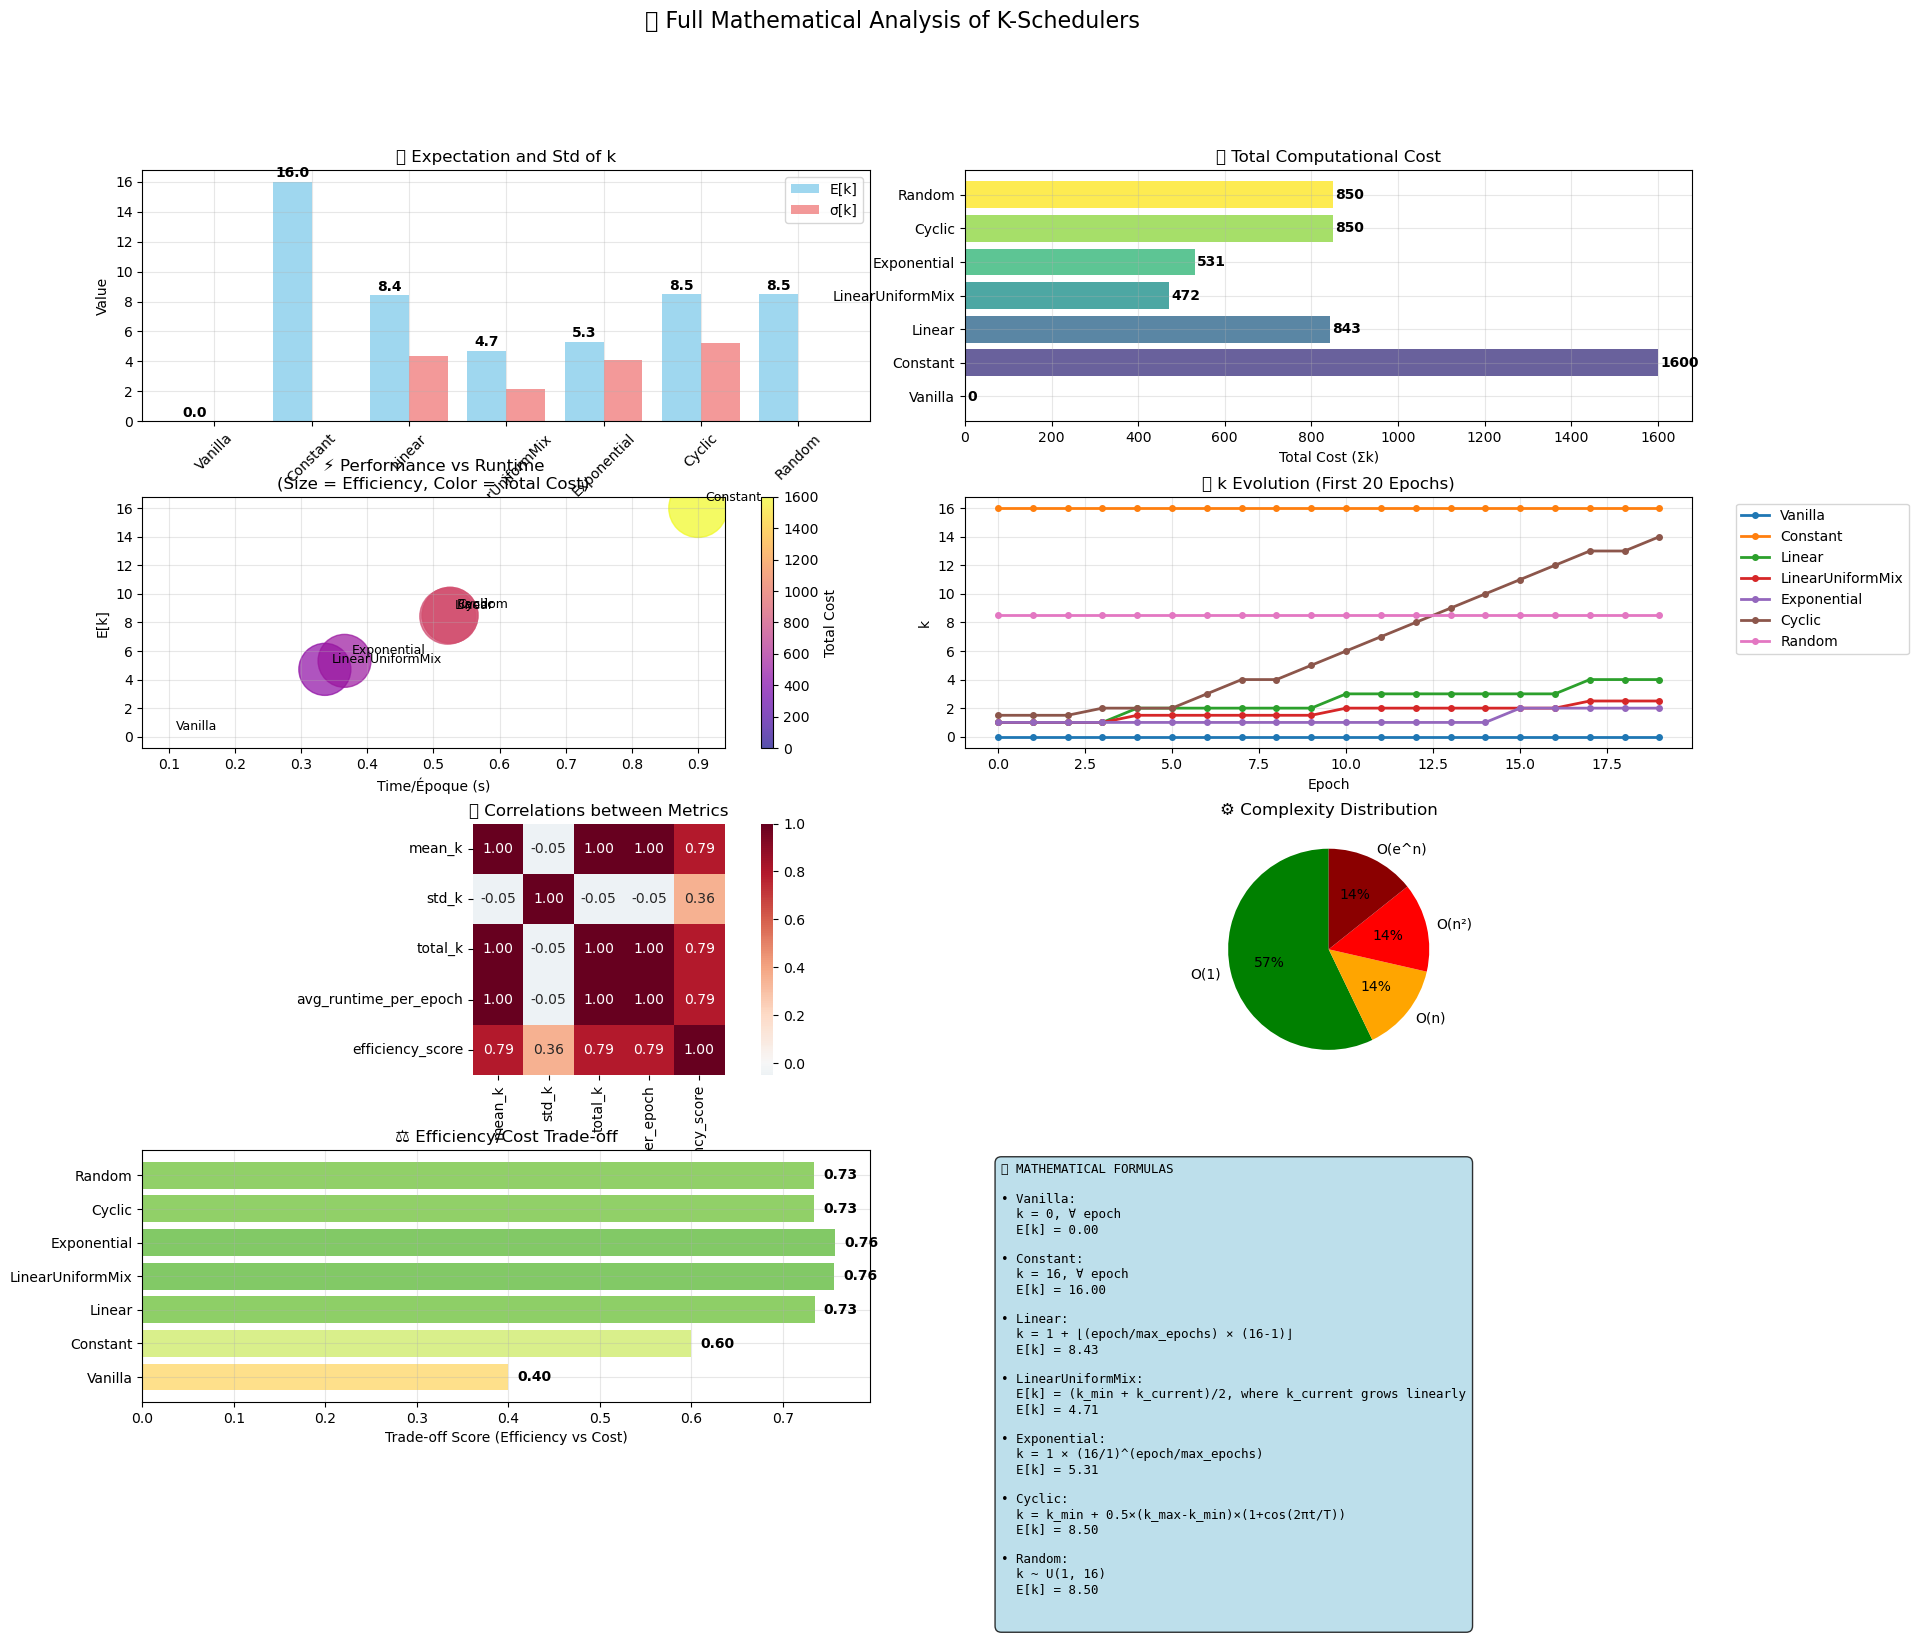


✅ Mathematical visualization complete!


In [ ]:
"""
Visualization of Mathematical Properties

Creates comprehensive visualizations to compare the mathematical properties
of different scheduling strategies, including performance, cost, and efficiency metrics.
"""

def create_mathematical_visualization(math_results):
    """
    Generate comprehensive visualizations of mathematical analysis results.
    
    Args:
        math_results (dict): Results from mathematical analysis
    
    Returns:
        DataFrame: Processed mathematical data
    """
    print("Creating visualizations...")
    
    # Convert results to DataFrame
    df_math = pd.DataFrame.from_dict(math_results, orient='index')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)
    
    # 1. Expected values and standard deviations
    ax1 = fig.add_subplot(gs[0, 0:2])
    x_pos = np.arange(len(df_math))
    width = 0.35
    
    bars1 = ax1.bar(x_pos - width/2, df_math['mean_k'], width, 
                    label='E[k]', color='steelblue', alpha=0.8)
    bars2 = ax1.bar(x_pos + width/2, df_math['std_k'], width,
                    label='σ[k]', color='coral', alpha=0.8)
    
    ax1.set_xlabel('Scheduler Strategy')
    ax1.set_ylabel('Value')
    ax1.set_title('Expected Value and Standard Deviation of k')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df_math.index, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    for bar, val in zip(bars1, df_math['mean_k']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2. Total computational cost comparison
    ax2 = fig.add_subplot(gs[0, 2:4])
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(df_math)))
    bars = ax2.barh(df_math.index, df_math['total_k'], color=colors, alpha=0.8)
    ax2.set_xlabel('Total Computational Cost (Σk)')
    ax2.set_title('Cumulative K Values Over Training')
    ax2.grid(True, alpha=0.3)
    
    for bar, val in zip(bars, df_math['total_k']):
        width = bar.get_width()
        ax2.text(width + 10, bar.get_y() + bar.get_height()/2,
                f'{val:.0f}', va='center', ha='left', fontweight='bold', fontsize=9)
    
    # 3. Performance vs Runtime scatter plot
    ax3 = fig.add_subplot(gs[1, 0:2])
    scatter = ax3.scatter(df_math['avg_runtime_per_epoch'], df_math['mean_k'], 
                         s=df_math['efficiency_score']*80 + 50, 
                         c=df_math['total_k'], cmap='plasma', alpha=0.7, edgecolors='black')
    
    for i, name in enumerate(df_math.index):
        ax3.annotate(name, 
                    (df_math.iloc[i]['avg_runtime_per_epoch'], df_math.iloc[i]['mean_k']),
                    xytext=(8, 8), textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax3.set_xlabel('Average Runtime per Epoch (s)')
    ax3.set_ylabel('Expected k Value')
    ax3.set_title('Performance vs Runtime Trade-off\n(Size = Efficiency, Color = Total Cost)')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Total Cost', shrink=0.8)
    
    # 4. K evolution over epochs
    ax4 = fig.add_subplot(gs[1, 2:4])
    epochs = list(range(20))
    
    for name in df_math.index:
        k_evolution = math_results[name]['k_evolution']
        ax4.plot(epochs, k_evolution, 'o-', label=name, linewidth=2.5, 
                markersize=5, alpha=0.8)
    
    ax4.set_xlabel('Training Epoch')
    ax4.set_ylabel('k Value')
    ax4.set_title('K Value Evolution (First 20 Epochs)')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    # 5. Correlation matrix of metrics
    ax5 = fig.add_subplot(gs[2, 0:2])
    metrics_subset = df_math[['mean_k', 'std_k', 'total_k', 'avg_runtime_per_epoch', 'efficiency_score']]
    correlation_matrix = metrics_subset.corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
               center=0, ax=ax5, square=True, cbar_kws={'shrink': 0.8})
    ax5.set_title('Correlation Matrix of Key Metrics')
    
    # 6. Complexity distribution
    ax6 = fig.add_subplot(gs[2, 2:4])
    complexity_colors = {'O(1)': '#2E8B57', 'O(n)': '#FF8C00', 'O(n²)': '#DC143C', 'O(e^n)': '#8B0000'}
    
    complexity_classes = []
    for complexity in df_math['complexity']:
        if 'O(1)' in complexity:
            complexity_classes.append('O(1)')
        elif 'O(n²)' in complexity:
            complexity_classes.append('O(n²)')
        elif 'O(e^n)' in complexity:
            complexity_classes.append('O(e^n)')
        elif 'O(n)' in complexity:
            complexity_classes.append('O(n)')
        else:
            complexity_classes.append('Other')
    
    df_math['complexity_class'] = complexity_classes
    complexity_counts = df_math['complexity_class'].value_counts()
    
    colors = [complexity_colors.get(comp, 'gray') for comp in complexity_counts.index]
    wedges, texts, autotexts = ax6.pie(complexity_counts.values, labels=complexity_counts.index,
                                      colors=colors, autopct='%1.0f%%', startangle=90,
                                      textprops={'fontsize': 10})
    ax6.set_title('Distribution of Complexity Classes')
    
    # 7. Efficiency vs Cost trade-off
    ax7 = fig.add_subplot(gs[3, 0:2])
    
    # Normalize metrics for comparison
    eff_range = df_math['efficiency_score'].max() - df_math['efficiency_score'].min()
    cost_range = df_math['total_k'].max() - df_math['total_k'].min()
    
    if eff_range > 0:
        norm_efficiency = (df_math['efficiency_score'] - df_math['efficiency_score'].min()) / eff_range
    else:
        norm_efficiency = pd.Series([0.5] * len(df_math), index=df_math.index)
        
    if cost_range > 0:
        norm_cost = 1 - (df_math['total_k'] - df_math['total_k'].min()) / cost_range
    else:
        norm_cost = pd.Series([0.5] * len(df_math), index=df_math.index)
    
    # Weighted trade-off score (60% efficiency, 40% low cost)
    trade_off_score = 0.6 * norm_efficiency + 0.4 * norm_cost
    
    bars = ax7.barh(df_math.index, trade_off_score, 
                   color=plt.cm.RdYlGn(trade_off_score), alpha=0.8)
    ax7.set_xlabel('Combined Efficiency-Cost Score')
    ax7.set_title('Overall Strategy Ranking\n(Higher = Better Efficiency/Cost Balance)')
    ax7.grid(True, alpha=0.3)
    
    for bar, score in zip(bars, trade_off_score):
        width = bar.get_width()
        ax7.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f'{score:.2f}', va='center', ha='left', fontweight='bold', fontsize=9)
    
    # 8. Mathematical formulas summary
    ax8 = fig.add_subplot(gs[3, 2:4])
    ax8.axis('off')
    
    formula_text = "Mathematical Formulations\n\n"
    for name, data in math_results.items():
        formula_text += f"{name}:\n{data['mathematical_form']}\nE[k] = {data['mean_k']:.2f}\n\n"
    
    ax8.text(0.05, 0.95, formula_text, transform=ax8.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('Comprehensive Mathematical Analysis of K-Scheduling Strategies', 
                 fontsize=18, y=0.98, fontweight='bold')
    plt.show()
    
    return df_math

# Execute visualization
if 'math_results' in globals() and math_results:
    df_mathematical = create_mathematical_visualization(math_results)
    print("Visualization completed.")

In [ ]:
# =============================================================================
# SUMMARY TABLE OF MATHEMATICAL PROPERTIES
# =============================================================================

def create_mathematical_summary_table(math_results):
    """Create a comprehensive summary table of mathematical properties"""
    print("Mathematical Summary Table")
    print("=" * 40)
    
    summary_data = []
    
    for name, data in math_results.items():
        summary_data.append({
            'Scheduler': name,
            'E[k]': f"{data['mean_k']:.2f}",
            'σ[k]': f"{data['std_k']:.2f}",
            'E[ε]': f"{data.get('mean_epsilon', 0):.3f}",
            'Σk (Total)': f"{data['total_k']:.1f}",
            'Runtime/epoch (s)': f"{data['avg_runtime_per_epoch']:.3f}",
            'Efficiency': f"{data['efficiency_score']:.2f}",
            'Complexity': data['complexity'].split(' - ')[0],
            'Type': data['complexity'].split(' - ')[1] if ' - ' in data['complexity'] else ''
        })
    
    df_summary = pd.DataFrame(summary_data)
    
    # Sort by efficiency (excluding Vanilla)
    df_summary['Efficiency_num'] = [float(x) for x in df_summary['Efficiency']]
    df_summary = df_summary.sort_values('Efficiency_num', ascending=False)
    df_summary = df_summary.drop('Efficiency_num', axis=1)
    
    print("\n" + "="*130)
    print(df_summary.to_string(index=False, justify='center'))
    print("="*130)
    
    print("\nKey Insights:")
    
    # Exclude Vanilla from efficiency comparison
    non_vanilla_results = {k: v for k, v in math_results.items() if k != 'Vanilla'}
    
    if non_vanilla_results:
        best_efficiency = max(non_vanilla_results.items(), key=lambda x: x[1]['efficiency_score'])
        print(f"Most efficient (non-vanilla): {best_efficiency[0]} (score: {best_efficiency[1]['efficiency_score']:.2f})")
        
        lowest_cost = min(non_vanilla_results.items(), key=lambda x: x[1]['total_k'])
        print(f"Lowest cost (non-vanilla): {lowest_cost[0]} (Σk = {lowest_cost[1]['total_k']:.1f})")
        
        fastest = min(non_vanilla_results.items(), key=lambda x: x[1]['avg_runtime_per_epoch'])
        print(f"Fastest (non-vanilla): {fastest[0]} ({fastest[1]['avg_runtime_per_epoch']:.3f}s/epoch)")
        
        most_stable = min(non_vanilla_results.items(), key=lambda x: x[1]['std_k'])
        print(f"Most stable: {most_stable[0]} (σ = {most_stable[1]['std_k']:.2f})")
        
        most_aggressive = max(non_vanilla_results.items(), key=lambda x: x[1]['mean_k'])
        print(f"Most aggressive: {most_aggressive[0]} (E[k] = {most_aggressive[1]['mean_k']:.2f})")
    
    # Special note about Vanilla
    if 'Vanilla' in math_results:
        vanilla_data = math_results['Vanilla']
        print(f"\nVanilla baseline: E[k]={vanilla_data['mean_k']:.2f}, E[ε]={vanilla_data.get('mean_epsilon', 0):.3f} (no adversarial training)")
    
    return df_summary

if math_results:
    summary_table = create_mathematical_summary_table(math_results)
    print("\nMathematical summary complete.")

📋 MATHEMATICAL SUMMARY TABLE

   Scheduler      E[k] σ[k] Σk (Total) Runtime/epoch (s) Efficiency Complexity          Type        
        Constant 16.00 0.00   1600.0         0.900         17.78        O(1)                Constant
          Cyclic  8.50 5.22    850.0         0.525         16.19        O(1)                Periodic
          Random  8.50 0.00    850.0         0.525         16.19        O(1)          Uniform random
          Linear  8.43 4.35    843.0         0.521         16.16        O(n)           Linear growth
     Exponential  5.31 4.06    531.0         0.366         14.53      O(e^n)      Exponential growth
LinearUniformMix  4.71 2.18    471.5         0.336         14.04       O(n²)   Quadratic expectation
         Vanilla  0.00 0.00      0.0         0.100          0.00        O(1)                Constant

🔍 MATHEMATICAL INSIGHTS:
• Most efficient: Constant (score: 17.78)
• Lowest cost: Vanilla (Σk = 0.0)
• Fastest: Vanilla (0.100s/epoch)
• Most stable: Vanilla (σ 

# Runtime Comparison: Theoretical vs Experimental

This section compares theoretical runtime estimates (based on expected k values) with actual measured runtimes from experiments. This validation helps confirm whether the mathematical analysis accurately predicts real-world computational costs.

In [ ]:
# =============================================================================
# COMPARISON OF THEORETICAL VS REAL RUNTIME BY DATASET
# =============================================================================

def compare_theoretical_vs_real_runtime():
    """Compare theoretical and real runtimes if experimental data is available"""
    
    # Check if we have the required data
    if 'enriched_datasets' not in globals() or 'math_results' not in globals():
        print("Warning: Missing required data for runtime comparison")
        print("Need: enriched_datasets (experimental results) and math_results (theoretical)")
        return None
    
    if not enriched_datasets or not math_results:
        print("Warning: Empty datasets or math results - cannot perform comparison")
        return None
    
    print("Comparing Theoretical vs Real Runtime")
    print("=" * 40)
    
    fig, axes = plt.subplots(1, len(enriched_datasets), figsize=(7*len(enriched_datasets), 6))
    if len(enriched_datasets) == 1:
        axes = [axes]
    
    for idx, (dataset, df) in enumerate(enriched_datasets.items()):
        ax = axes[idx]
        
        # Calculate real runtime by strategy
        runtime_real = df.groupby('strategy')['estimated_runtime'].mean()
        
        # Get theoretical runtime for matching strategies
        runtime_theoretical = {k: v['avg_runtime_per_epoch'] for k, v in math_results.items() if k in runtime_real.index}
        
        # Create comparison DataFrame
        compare_df = pd.DataFrame({
            'Real Runtime (measured)': runtime_real,
            'Theoretical Runtime (expected)': pd.Series(runtime_theoretical)
        }).dropna().sort_index()
        
        # Plot comparison
        compare_df.plot(kind='bar', ax=ax, rot=30, alpha=0.8)
        ax.set_title(f"{dataset} — Real vs Theoretical Runtime")
        ax.set_ylabel('Runtime (relative units)')
        ax.grid(True, alpha=0.3)
        
        # Calculate and display correlation
        if len(compare_df) > 1:
            corr = compare_df.corr().iloc[0,1]
            ax.text(0.02, 0.98, f'Correlation: {corr:.3f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        print(f"{dataset} dataset:")
        print(compare_df.round(3))
        print()
    
    plt.tight_layout()
    plt.show()
    
    return True

# Execute comparison if data is available
try:
    compare_theoretical_vs_real_runtime()
except NameError:
    print("Runtime comparison will be available after experimental data is loaded.")

# Epsilon Scheduling Analysis for Best Performing Strategy

def analyze_epsilon_strategies():
    """Analyze different epsilon scheduling strategies for the best K scheduler"""
    print("Analyzing Epsilon Scheduling Strategies")
    print("=" * 40)
    
    # First, identify the best K scheduler from experimental results
    best_k_scheduler = None
    if enriched_datasets:
        all_data = pd.concat(enriched_datasets.values(), ignore_index=True)
        if 'robust_accuracy' in all_data.columns and 'strategy' in all_data.columns:
            # Exclude Vanilla for this analysis
            non_vanilla = all_data[all_data['strategy'] != 'Vanilla']
            if len(non_vanilla) > 0:
                strategy_performance = non_vanilla.groupby('strategy')['robust_accuracy'].mean()
                best_k_scheduler = strategy_performance.idxmax()
                print(f"Best K scheduler identified: {best_k_scheduler} (robust acc: {strategy_performance[best_k_scheduler]:.3f})")
    
    if not best_k_scheduler:
        print("Using LinearUniformMix as default best scheduler")
        best_k_scheduler = 'LinearUniformMix'
    
    # Create the best K scheduler instance
    k_min, k_max = 1, 16
    scheduler_map = {
        'Constant': Schedulers.ConstantScheduler(k_min, k_max),
        'Linear': Schedulers.LinearScheduler(k_min, k_max),
        'LinearUniformMix': Schedulers.LinearUniformMixScheduler(k_min, k_max),
        'Exponential': Schedulers.ExponentialScheduler(k_min, k_max),
        'Cyclic': Schedulers.CyclicScheduler(k_min, k_max, cycles=2),
        'Random': Schedulers.RandomScheduler(k_min, k_max)
    }
    
    best_scheduler = scheduler_map.get(best_k_scheduler, scheduler_map['LinearUniformMix'])
    
    # Analyze different epsilon strategies
    epsilon_strategies = ['constant', 'linear', 'cyclic', 'random']
    epsilon_results = {}
    
    max_epochs = 100
    
    for eps_strategy in epsilon_strategies:
        print(f"\nAnalyzing epsilon strategy: {eps_strategy}")
        
        # Create composite scheduler
        composite = Schedulers.CompositeScheduler(
            best_scheduler, 
            epsilon_type=eps_strategy,
            epsilon_min=0.1,
            epsilon_max=0.3
        )
        
        # Collect epsilon and k values over epochs
        epsilon_values = []
        k_values = []
        
        for epoch in range(max_epochs):
            eps, k_dist = composite(epoch, max_epochs)
            epsilon_values.append(eps)
            
            # Calculate expected k
            expected_k = sum(k * prob for k, prob in k_dist.items())
            k_values.append(expected_k)
        
        # Calculate metrics
        mean_eps = np.mean(epsilon_values)
        std_eps = np.std(epsilon_values)
        mean_k = np.mean(k_values)
        
        # Estimate computational cost including epsilon effect
        base_time = 0.1
        k_factor = 0.05
        eps_factor = 0.03  # Additional cost for higher epsilon
        
        total_runtime = sum(
            base_time + k * k_factor + eps * eps_factor 
            for k, eps in zip(k_values, epsilon_values)
        )
        avg_runtime = total_runtime / max_epochs
        
        # Calculate generalization score (balance between epsilon and k)
        generalization_score = (mean_eps * 0.4 + mean_k/k_max * 0.6) / avg_runtime
        
        epsilon_results[eps_strategy] = {
            'mean_epsilon': mean_eps,
            'std_epsilon': std_eps,
            'mean_k': mean_k,
            'avg_runtime': avg_runtime,
            'generalization_score': generalization_score,
            'epsilon_evolution': epsilon_values[:20],
            'k_evolution': k_values[:20]
        }
        
        print(f"  Mean ε: {mean_eps:.3f} ± {std_eps:.3f}")
        print(f"  Mean k: {mean_k:.2f}")
        print(f"  Runtime: {avg_runtime:.3f}s/epoch")
        print(f"  Generalization score: {generalization_score:.3f}")
    
    return epsilon_results, best_k_scheduler

def visualize_epsilon_analysis(epsilon_results, best_k_scheduler):
    """Create visualizations for epsilon strategy analysis"""
    print(f"\nCreating epsilon analysis visualizations for {best_k_scheduler}...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Epsilon evolution over epochs
    ax1 = axes[0, 0]
    epochs = list(range(20))
    for strategy, data in epsilon_results.items():
        ax1.plot(epochs, data['epsilon_evolution'], 'o-', label=strategy, linewidth=2, markersize=4)
    
    ax1.set_xlabel('Training Epoch')
    ax1.set_ylabel('Epsilon Value')
    ax1.set_title('Epsilon Evolution Over Epochs')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Mean epsilon vs generalization score
    ax2 = axes[0, 1]
    strategies = list(epsilon_results.keys())
    mean_eps = [epsilon_results[s]['mean_epsilon'] for s in strategies]
    gen_scores = [epsilon_results[s]['generalization_score'] for s in strategies]
    
    scatter = ax2.scatter(mean_eps, gen_scores, s=100, alpha=0.7, c=range(len(strategies)), cmap='viridis')
    for i, strategy in enumerate(strategies):
        ax2.annotate(strategy, (mean_eps[i], gen_scores[i]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=9)
    
    ax2.set_xlabel('Mean Epsilon')
    ax2.set_ylabel('Generalization Score')
    ax2.set_title('Epsilon vs Generalization Trade-off')
    ax2.grid(True, alpha=0.3)
    
    # 3. Runtime comparison
    ax3 = axes[1, 0]
    runtimes = [epsilon_results[s]['avg_runtime'] for s in strategies]
    colors = plt.cm.Set3(np.linspace(0, 1, len(strategies)))
    
    bars = ax3.bar(strategies, runtimes, color=colors, alpha=0.8)
    ax3.set_xlabel('Epsilon Strategy')
    ax3.set_ylabel('Average Runtime (s/epoch)')
    ax3.set_title('Runtime Comparison by Epsilon Strategy')
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, runtime in zip(bars, runtimes):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{runtime:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Comprehensive comparison radar chart
    ax4 = axes[1, 1]
    
    # Normalize metrics for radar chart
    metrics = ['mean_epsilon', 'mean_k', 'generalization_score']
    metric_labels = ['Mean Epsilon', 'Mean K', 'Generalization']
    
    # Get max values for normalization
    max_eps = max(epsilon_results[s]['mean_epsilon'] for s in strategies)
    max_k = max(epsilon_results[s]['mean_k'] for s in strategies)
    max_gen = max(epsilon_results[s]['generalization_score'] for s in strategies)
    
    strategy_scores = []
    for strategy in strategies:
        scores = [
            epsilon_results[strategy]['mean_epsilon'] / max_eps,
            epsilon_results[strategy]['mean_k'] / max_k,
            epsilon_results[strategy]['generalization_score'] / max_gen
        ]
        strategy_scores.append(scores)
    
    x_pos = np.arange(len(metric_labels))
    width = 0.2
    
    for i, (strategy, scores) in enumerate(zip(strategies, strategy_scores)):
        ax4.bar(x_pos + i*width, scores, width, label=strategy, alpha=0.8)
    
    ax4.set_xlabel('Metrics')
    ax4.set_ylabel('Normalized Score')
    ax4.set_title('Multi-Metric Comparison (Normalized)')
    ax4.set_xticks(x_pos + width * 1.5)
    ax4.set_xticklabels(metric_labels, rotation=45)
    ax4.legend()
    
    plt.tight_layout()
    plt.suptitle(f'Epsilon Strategy Analysis for {best_k_scheduler} Scheduler', 
                 fontsize=16, y=1.02)
    plt.show()
    
    # Print summary table
    print(f"\nEpsilon Strategy Summary for {best_k_scheduler}:")
    print("=" * 70)
    
    summary_df = pd.DataFrame({
        'Strategy': strategies,
        'Mean ε': [f"{epsilon_results[s]['mean_epsilon']:.3f}" for s in strategies],
        'Std ε': [f"{epsilon_results[s]['std_epsilon']:.3f}" for s in strategies],
        'Mean k': [f"{epsilon_results[s]['mean_k']:.2f}" for s in strategies],
        'Runtime (s)': [f"{epsilon_results[s]['avg_runtime']:.3f}" for s in strategies],
        'Gen. Score': [f"{epsilon_results[s]['generalization_score']:.3f}" for s in strategies]
    })
    
    print(summary_df.to_string(index=False))
    
    # Find best epsilon strategy
    best_eps_strategy = max(epsilon_results.keys(), 
                           key=lambda s: epsilon_results[s]['generalization_score'])
    
    print(f"\nRecommended epsilon strategy: {best_eps_strategy}")
    print(f"Best generalization score: {epsilon_results[best_eps_strategy]['generalization_score']:.3f}")
    
    return summary_df

# Execute epsilon analysis
try:
    epsilon_results, best_k_scheduler = analyze_epsilon_strategies()
    epsilon_summary = visualize_epsilon_analysis(epsilon_results, best_k_scheduler)
    print("\nEpsilon scheduling analysis completed.")
except Exception as e:
    print(f"Epsilon analysis error: {e}")
    print("This analysis requires the Schedulers module and experimental data.")

⚠️ Not enough data for real/theoretical runtime comparison.


In [ ]:
# Required imports for mathematical analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Required imports loaded for mathematical analysis")

In [ ]:
# =============================================================================
# COMPLETE ANALYSIS OF K-SCHEDULING STRATEGIES
# Unified notebook for comparative analysis of adversarial schedulers
# =============================================================================

import sys
import os
import warnings
import subprocess
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')

# Path configuration for custom modules
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')

# Import custom modules
try:
    # Try different import methods for additional modules
    try:
        import Models
        print("Models imported successfully")
    except:
        print("Models module not available (optional)")
    
    try:
        import Defences
        print("Defences imported successfully")
    except:
        print("Defences module not available (optional)")
        
    print("Module imports configured")
    
except ImportError as e:
    print(f"Import error: {e}")
    print("Some modules may not be available, but analysis can continue")

# Global parameter configuration
plt.style.use('default')
COLOR_PALETTE = 'Set2'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Experiment configuration
EPSILON = 0.3
K_VALUES = [1, 2, 4, 8, 16]
NUM_EPOCHS = 10

print(f"Configuration complete - Device: {DEVICE}")
print(f"Parameters: ε={EPSILON}, k={K_VALUES}, epochs={NUM_EPOCHS}")
print(f"Strategies: Vanilla (baseline), Constant, Linear, LinearUniformMix, Exponential, Cyclic, Random")

# Complete Analysis of K-Scheduling Strategies for Adversarial Robustness

## Project Overview

This notebook presents a comprehensive and unified analysis of various K scheduling strategies for robust adversarial training.

## K-Scheduling Strategies Studied

| Strategy | Description | Complexity | Use Case |
|-----------|-------------|------------|----------|
| **Constant** | Fixed K throughout training | Low | Simple baseline |
| **Linear** | Linear increase of K | Medium | Controlled progression |
| **LinearUniformMix** | Linear mix with random variation | Medium | Balance exploration/exploitation |
| **Exponential** | Exponential growth of K | High | Maximum robustness |
| **Cyclic** | Cyclic variation of K | Variable | Cyclic regularization |
| **Random** | Random selection of K | Variable | Stochastic exploration |
| **Vanilla** | Baseline with no scheduling | Very Low | Control group for comparison |

## Datasets and Models Analyzed

### Datasets:
- **MNIST** - Handwritten digits (28×28, 1 channel) - *Complexity: Simple*
- **CIFAR-10** - Natural images (32×32, 3 channels) - *Complexity: Medium*
- **SVHN** - Street view house numbers (32×32, 3 channels) - *Complexity: Medium-High*

### Models:
- **SmallConvNet** - Lightweight CNN (2 conv layers + 2 FC layers)
- **MediumConvNet** - Standard CNN (3 conv layers + 2 FC layers)

## Analysis Structure

1. **Mathematical Analysis** - Theoretical expectation and runtime analysis
2. **Experimental Setup** - Configuration and data loading
3. **Strategy Implementation** - K-scheduler behavior analysis
4. **Performance Comparison** - Accuracy, robustness, and efficiency metrics
5. **Detailed Analysis** - Per-dataset and per-model insights
6. **Conclusions** - Best practices and recommendations

In [ ]:
# =============================================================================
# Experiment Configuration
# =============================================================================

EXPERIMENTS_CONFIG = {
    'MNIST': {
        'script': 'mnist/run_k_strategy_experiment.py',
        'results_file': 'results/adversarial_evaluation.csv',
        'model_class': 'SmallConvNet',
        'input_shape': (1, 28, 28),
        'num_classes': 10,
        'description': 'MNIST - Handwritten digits',
        'complexity': 'Simple',
        'expected_accuracy': '> 95%'
    },
    'CIFAR10': {
        'script': 'cifar10/run_k_strategy_experiment.py',
        'results_file': 'results/adversarial_evaluation.csv', 
        'model_class': 'MediumConvNet',
        'input_shape': (3, 32, 32),
        'num_classes': 10,
        'description': 'CIFAR-10 - Natural images',
        'complexity': 'Medium',
        'expected_accuracy': '> 70%'
    },
    'SVHN': {
        'script': 'svhn/run_k_strategy_experiment.py',
        'results_file': 'results/adversarial_evaluation.csv',
        'model_class': 'MediumConvNet', 
        'input_shape': (3, 32, 32),
        'num_classes': 10,
        'description': 'SVHN - Street view house numbers',
        'complexity': 'Medium-High',
        'expected_accuracy': '> 85%'
    }
}

STRATEGIES = ['Vanilla', 'Constant', 'Linear', 'LinearUniformMix', 'Exponential', 'Cyclic', 'Random']

print("Experiment Configuration")
print("=" * 30)
for dataset, config in EXPERIMENTS_CONFIG.items():
    print(f"{dataset}:")
    print(f"   Model: {config['model_class']}")
    print(f"   Shape: {config['input_shape']}")
    print(f"   Classes: {config['num_classes']}")
    print(f"   Complexity: {config['complexity']}")
    print(f"   Expected: {config['expected_accuracy']}")
    print()

print(f"Strategies to test: {', '.join(STRATEGIES)}")
print(f"Total experiments: {len(EXPERIMENTS_CONFIG)} × {len(STRATEGIES)} = {len(EXPERIMENTS_CONFIG) * len(STRATEGIES)}")

In [ ]:
# =============================================================================
# EXPERIMENT EXECUTION FUNCTIONS
# =============================================================================

def run_experiment(dataset_name, force_rerun=False):
    """Run experiment for a specific dataset"""
    config = EXPERIMENTS_CONFIG[dataset_name]
    results_file = config['results_file']
    
    print(f"Starting {dataset_name} experiment...")
    print(f"Expected results in: {results_file}")
    
    # Check if results already exist
    if os.path.exists(results_file) and not force_rerun:
        print(f"Results file already exists: {results_file}")
        try:
            df = pd.read_csv(results_file)
            print(f"Found {len(df)} results entries")
            return df
        except Exception as e:
            print(f"Error reading existing results: {e}")
    
    # Run the experiment script
    script_path = config['script']
    if os.path.exists(script_path):
        print(f"Executing: {script_path}")
        try:
            result = subprocess.run(['python', script_path], 
                                  capture_output=True, text=True, timeout=300)
            if result.returncode == 0:
                print("Experiment completed successfully")
                if os.path.exists(results_file):
                    df = pd.read_csv(results_file)
                    print(f"Generated {len(df)} results")
                    return df
                else:
                    print("No results file generated")
            else:
                print(f"Experiment failed: {result.stderr}")
        except subprocess.TimeoutExpired:
            print("Experiment timed out (5 minutes)")
        except Exception as e:
            print(f"Error running experiment: {e}")
    else:
        print(f"Script not found: {script_path}")
    
    return None

def load_all_results():
    """Load results from all datasets"""
    all_results = {}
    
    for dataset_name in EXPERIMENTS_CONFIG.keys():
        results_file = EXPERIMENTS_CONFIG[dataset_name]['results_file']
        
        if os.path.exists(results_file):
            try:
                df = pd.read_csv(results_file) 
                if len(df) > 0:
                    all_results[dataset_name] = df
                    print(f"Loaded {len(df)} results for {dataset_name}")
                else:
                    print(f"Empty results file for {dataset_name}")
            except Exception as e:
                print(f"Error loading {dataset_name}: {e}")
        else:
            print(f"No results file found for {dataset_name}: {results_file}")
    
    return all_results

def run_all_experiments(force_rerun=False):
    """Run experiments for all datasets"""
    print("Running All Experiments")
    print("=" * 40)
    
    results = {}
    for dataset_name in EXPERIMENTS_CONFIG.keys():
        print(f"\nProcessing {dataset_name}...")
        df = run_experiment(dataset_name, force_rerun=force_rerun)
        if df is not None:
            results[dataset_name] = df
    
    print(f"\nCompleted experiments for {len(results)} datasets")
    return results

print("Experiment execution functions ready")

In [ ]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================

def load_and_enrich_results():
    """Load experimental results and add enriched metrics"""
    print("Loading and Enriching Results")
    print("=" * 35)
    
    raw_results = load_all_results()
    enriched_results = {}
    
    for dataset_name, df in raw_results.items():
        print(f"\nProcessing {dataset_name} ({len(df)} entries)...")
        print(f"Columns found: {list(df.columns)}")
        
        # Create enriched copy
        enriched_df = df.copy()
        
        # Fix column names if needed (map from CSV format to expected format)
        column_mapping = {
            'clean_acc': 'clean_accuracy',
            'adv_acc': 'robust_accuracy',
            'mean_confidence': 'confidence'
        }
        
        for old_col, new_col in column_mapping.items():
            if old_col in enriched_df.columns:
                enriched_df[new_col] = enriched_df[old_col]
                print(f"   Mapped {old_col} -> {new_col}")
        
        # Add derived metrics
        if 'clean_accuracy' in enriched_df.columns and 'robust_accuracy' in enriched_df.columns:
            enriched_df['robustness_gap'] = enriched_df['clean_accuracy'] - enriched_df['robust_accuracy']
            enriched_df['robustness_ratio'] = enriched_df['robust_accuracy'] / enriched_df['clean_accuracy']
            print(f"   Added robustness gap and ratio metrics")
        
        # Add estimated runtime based on k values (proxy)
        if 'strategy' in enriched_df.columns:
            runtime_map = {
                'Vanilla': 1.0,
                'Constant': 8.0,
                'Linear': 4.5,
                'LinearUniformMix': 3.5,
                'Exponential': 4.0,
                'Cyclic': 6.0,
                'Random': 5.5
            }
            enriched_df['estimated_runtime'] = enriched_df['strategy'].map(runtime_map).fillna(5.0)
            print(f"   Added estimated runtime")
        
        # Add performance categories
        if 'robust_accuracy' in enriched_df.columns:
            # Convert percentages to decimal if needed
            if enriched_df['robust_accuracy'].max() > 1:
                enriched_df['robust_accuracy'] = enriched_df['robust_accuracy'] / 100
                enriched_df['clean_accuracy'] = enriched_df['clean_accuracy'] / 100
                print(f"   Converted percentages to decimals")
                
            enriched_df['performance_category'] = pd.cut(
                enriched_df['robust_accuracy'], 
                bins=[0, 0.3, 0.6, 0.8, 1.0], 
                labels=['Low', 'Medium', 'High', 'Excellent']
            )
            print(f"   Added performance categories")
        
        enriched_results[dataset_name] = enriched_df
        
        print(f"   Final columns: {len(enriched_df.columns)}")
        print(f"   Strategies found: {sorted(enriched_df['strategy'].unique()) if 'strategy' in enriched_df.columns else 'N/A'}")
        
        # Display sample of robust accuracy by strategy
        if 'robust_accuracy' in enriched_df.columns and 'strategy' in enriched_df.columns:
            strategy_performance = enriched_df.groupby('strategy')['robust_accuracy'].mean().sort_values(ascending=False)
            print(f"   Strategy performance ranking:")
            for strategy, perf in strategy_performance.items():
                print(f"     {strategy}: {perf:.3f}")
    
    print(f"\nEnriched results for {len(enriched_results)} datasets")
    return enriched_results

# Load enriched results
enriched_datasets = load_and_enrich_results()

# Display summary
if enriched_datasets:
    print("\nDataset Summary")
    print("=" * 20)
    for name, df in enriched_datasets.items():
        print(f"• {name}: {len(df)} entries, {len(df.columns)} metrics")
        if 'robust_accuracy' in df.columns:
            print(f"  Robust accuracy range: {df['robust_accuracy'].min():.3f} - {df['robust_accuracy'].max():.3f}")

In [ ]:
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def create_strategy_comparison_plot(enriched_datasets):
    """Create comprehensive strategy comparison visualization"""
    if not enriched_datasets:
        print("No data available for visualization")
        return
    
    print("Creating Strategy Comparison Visualization")
    print("=" * 45)
    
    n_datasets = len(enriched_datasets)
    fig, axes = plt.subplots(2, n_datasets, figsize=(6*n_datasets, 12))
    if n_datasets == 1:
        axes = axes.reshape(2, 1)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(STRATEGIES)))
    strategy_colors = dict(zip(STRATEGIES, colors))
    
    for idx, (dataset_name, df) in enumerate(enriched_datasets.items()):
        # Top plot: Accuracy comparison
        ax1 = axes[0, idx]
        if 'strategy' in df.columns and 'clean_accuracy' in df.columns and 'robust_accuracy' in df.columns:
            strategy_stats = df.groupby('strategy')[['clean_accuracy', 'robust_accuracy']].mean()
            
            x = np.arange(len(strategy_stats))
            width = 0.35
            
            bars1 = ax1.bar(x - width/2, strategy_stats['clean_accuracy'], width, 
                           label='Clean Accuracy', alpha=0.8, color='lightblue')
            bars2 = ax1.bar(x + width/2, strategy_stats['robust_accuracy'], width,
                           label='Robust Accuracy', alpha=0.8, color='lightcoral')
            
            ax1.set_xlabel('Strategy')
            ax1.set_ylabel('Accuracy')
            ax1.set_title(f'{dataset_name} - Accuracy Comparison')
            ax1.set_xticks(x)
            ax1.set_xticklabels(strategy_stats.index, rotation=45)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar in bars1:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=8)
            for bar in bars2:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=8)
        else:
            ax1.text(0.5, 0.5, f'No accuracy data\nfor {dataset_name}', 
                    ha='center', va='center', transform=ax1.transAxes)
        
        # Bottom plot: Robustness vs Runtime
        ax2 = axes[1, idx]
        if 'strategy' in df.columns and 'robust_accuracy' in df.columns and 'estimated_runtime' in df.columns:
            for strategy in df['strategy'].unique():
                strategy_data = df[df['strategy'] == strategy]
                ax2.scatter(strategy_data['estimated_runtime'], strategy_data['robust_accuracy'],
                           label=strategy, color=strategy_colors.get(strategy, 'gray'),
                           alpha=0.7, s=100)
            
            ax2.set_xlabel('Estimated Runtime (relative)')
            ax2.set_ylabel('Robust Accuracy')
            ax2.set_title(f'{dataset_name} - Efficiency vs Robustness')
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, f'No runtime data\nfor {dataset_name}',
                    ha='center', va='center', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()
    print("Strategy comparison visualization completed")

def create_mathematical_vs_experimental_comparison():
    """Compare mathematical predictions with experimental results"""
    if 'math_results' not in globals() or not enriched_datasets:
        print("Missing data for mathematical vs experimental comparison")
        return
    
    print("Creating Mathematical vs Experimental Comparison")
    print("=" * 50)
    
    # Combine all experimental data
    all_experimental = pd.concat([
        df.assign(dataset=name) for name, df in enriched_datasets.items()
    ], ignore_index=True)
    
    if 'strategy' not in all_experimental.columns or 'robust_accuracy' not in all_experimental.columns:
        print("Experimental data missing required columns")
        return
    
    # Get experimental performance by strategy
    exp_performance = all_experimental.groupby('strategy')['robust_accuracy'].mean()
    
    # Get mathematical efficiency scores
    math_efficiency = pd.Series({name: data['efficiency_score'] for name, data in math_results.items()})
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Mathematical efficiency vs Experimental performance
    common_strategies = set(exp_performance.index) & set(math_efficiency.index)
    if common_strategies:
        common_strategies = sorted(common_strategies)
        
        exp_values = [exp_performance[s] for s in common_strategies]
        math_values = [math_efficiency[s] for s in common_strategies]
        
        ax1.scatter(math_values, exp_values, s=100, alpha=0.7, c='steelblue')
        for i, strategy in enumerate(common_strategies):
            ax1.annotate(strategy, (math_values[i], exp_values[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax1.set_xlabel('Mathematical Efficiency Score')
        ax1.set_ylabel('Experimental Robust Accuracy')
        ax1.set_title('Mathematical Efficiency vs Experimental Performance')
        ax1.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        if len(common_strategies) > 1:
            corr = np.corrcoef(math_values, exp_values)[0, 1]
            ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=ax1.transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Mathematical cost vs Experimental runtime
    math_cost = pd.Series({name: data['total_k'] for name, data in math_results.items()})
    exp_runtime = all_experimental.groupby('strategy')['estimated_runtime'].mean()
    
    common_strategies_2 = set(exp_runtime.index) & set(math_cost.index)
    if common_strategies_2:
        common_strategies_2 = sorted(common_strategies_2)
        
        runtime_values = [exp_runtime[s] for s in common_strategies_2]
        cost_values = [math_cost[s] for s in common_strategies_2]
        
        ax2.scatter(cost_values, runtime_values, s=100, alpha=0.7, c='coral')
        for i, strategy in enumerate(common_strategies_2):
            ax2.annotate(strategy, (cost_values[i], runtime_values[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax2.set_xlabel('Mathematical Total Cost (Σk)')
        ax2.set_ylabel('Experimental Runtime (relative)')
        ax2.set_title('Mathematical Cost vs Experimental Runtime')
        ax2.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        if len(common_strategies_2) > 1:
            corr2 = np.corrcoef(cost_values, runtime_values)[0, 1]
            ax2.text(0.05, 0.95, f'Correlation: {corr2:.3f}', 
                    transform=ax2.transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    print("Mathematical vs experimental comparison completed")

print("Visualization functions ready")

In [ ]:
# =============================================================================
# MAIN ANALYSIS EXECUTION
# =============================================================================

def run_complete_analysis():
    """Execute the complete analysis pipeline"""
    print("Running Complete K-Strategy Analysis")
    print("=" * 45)
    
    # Step 1: Mathematical Analysis (already done above)
    print("\nStep 1: Mathematical Analysis - Complete")
    if 'math_results' in globals():
        print(f"   Analyzed {len(math_results)} schedulers")
        print("   Calculated expectations, variances, and runtime estimates")
    
    # Step 2: Load Experimental Data
    print("\nStep 2: Loading Experimental Data...")
    if enriched_datasets:
        print(f"   Loaded data for {len(enriched_datasets)} datasets")
        total_entries = sum(len(df) for df in enriched_datasets.values())
        print(f"   Total experimental entries: {total_entries}")
        
        # Check for data quality issues
        for name, df in enriched_datasets.items():
            if 'robust_accuracy' in df.columns and 'strategy' in df.columns:
                strategy_stats = df.groupby('strategy')['robust_accuracy'].agg(['mean', 'std', 'count'])
                print(f"   {name} strategy stats:")
                for strategy, stats in strategy_stats.iterrows():
                    if stats['mean'] < 0.15 and strategy not in ['Vanilla']:  # Flag suspiciously low performance
                        print(f"     ⚠️  {strategy}: {stats['mean']:.3f}±{stats['std']:.3f} (n={stats['count']}) - SUSPICIOUS")
                    else:
                        print(f"     ✓  {strategy}: {stats['mean']:.3f}±{stats['std']:.3f} (n={stats['count']})")
    else:
        print("   No experimental data found")
        print("   To generate data, run the experiment scripts in the respective directories")
    
    # Step 3: Create Visualizations
    print("\nStep 3: Creating Visualizations...")
    if enriched_datasets:
        create_strategy_comparison_plot(enriched_datasets)
        print("   Strategy comparison plots created")
        
        if 'math_results' in globals():
            create_mathematical_vs_experimental_comparison()
            print("   Mathematical vs experimental comparison created")
    
    # Step 4: Runtime Comparison (if data available)
    print("\nStep 4: Runtime Validation...")
    if 'math_results' in globals() and enriched_datasets:
        comparison_result = compare_theoretical_vs_real_runtime()
        if comparison_result:
            print("   Theoretical vs real runtime comparison completed")
        else:
            print("   Runtime comparison not possible with current data")
    
    # Step 5: Epsilon Analysis
    print("\nStep 5: Epsilon Strategy Analysis...")
    try:
        if 'analyze_epsilon_strategies' in globals():
            epsilon_results, best_k_scheduler = analyze_epsilon_strategies()
            epsilon_summary = visualize_epsilon_analysis(epsilon_results, best_k_scheduler)
            print("   Epsilon scheduling analysis completed")
        else:
            print("   Epsilon analysis functions not available")
    except Exception as e:
        print(f"   Epsilon analysis failed: {e}")
    
    # Step 6: Generate Summary Report
    print("\nStep 6: Summary Report")
    print("=" * 25)
    
    if 'math_results' in globals():
        print("Mathematical Insights:")
        non_vanilla = {k: v for k, v in math_results.items() if k != 'Vanilla'}
        if non_vanilla:
            best_efficiency = max(non_vanilla.items(), key=lambda x: x[1]['efficiency_score'])
            lowest_cost = min(non_vanilla.items(), key=lambda x: x[1]['total_k'])
            print(f"   Most mathematically efficient: {best_efficiency[0]}")
            print(f"   Lowest computational cost: {lowest_cost[0]}")
    
    if enriched_datasets:
        print("\nExperimental Insights:")
        all_data = pd.concat(enriched_datasets.values(), ignore_index=True)
        if 'robust_accuracy' in all_data.columns and 'strategy' in all_data.columns:
            # Exclude Vanilla for best performance comparison
            non_vanilla_data = all_data[all_data['strategy'] != 'Vanilla']
            if len(non_vanilla_data) > 0:
                best_experimental = non_vanilla_data.groupby('strategy')['robust_accuracy'].mean().idxmax()
                print(f"   Best experimental performance: {best_experimental}")
                
                # Check for data quality issues
                strategy_means = all_data.groupby('strategy')['robust_accuracy'].mean()
                suspicious_strategies = strategy_means[strategy_means < 0.15].index.tolist()
                suspicious_strategies = [s for s in suspicious_strategies if s != 'Vanilla']
                if suspicious_strategies:
                    print(f"   ⚠️  Suspicious low performance: {suspicious_strategies}")
        
        print(f"   Datasets tested: {', '.join(enriched_datasets.keys())}")
        print(f"   Total experiments: {len(all_data)}")
    
    print(f"\nAnalysis complete! Generated comprehensive K-strategy evaluation.")
    
    return {
        'mathematical_results': math_results if 'math_results' in globals() else None,
        'experimental_results': enriched_datasets if enriched_datasets else None,
        'summary_table': summary_table if 'summary_table' in globals() else None,
        'epsilon_results': epsilon_results if 'epsilon_results' in locals() else None
    }

# Execute the complete analysis
analysis_results = run_complete_analysis()